# Self-supervised and multi-modal representation Learning: Notebook 3

Here we will align the image and light curve representations with contrastive learning, using CLIP (https://openai.com/research/clip). Optionally, we can use the light curve encoder we trained previously.

<img src=./assets/clip.png alt= “” width=1024>

- From https://openai.com/research/clip.

## Aligning light curves and galaxy images in a common embedding space

In [1]:
import os, sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
from einops import rearrange

from IPython.display import Image as IPImage

%load_ext autoreload
%autoreload 2

### Data preprocessing

Load host images and inspect shape.

In [2]:
#data_dir = "../data/ZTFBTS/"  # If unzipped locally
data_dir = "/ocean/projects/phy230064p/shared/ZTFBTS/" # If running on Bridges-2

In [3]:
dir_host_imgs = f"{data_dir}/hostImgs/"
host_imgs = []

for filename in os.listdir(dir_host_imgs):
    file_path = os.path.join(dir_host_imgs, filename)
    if file_path.endswith(".png"):
        host_img = Image.open(file_path).convert('RGB')
        host_img = np.asarray(host_img)
        host_imgs.append(host_img)

host_imgs = np.array(host_imgs)

host_imgs = torch.from_numpy(host_imgs).float()
host_imgs = rearrange(host_imgs, 'b h w c -> b c h w')

# Normalize
host_imgs /= 255.0

Load light curves and pre-process them just like in the previous notebook.

In [4]:
dir_light_curves =  f"{data_dir}/light-curves/"

def open_light_curve_csv(filename):
    file_path = os.path.join(dir_light_curves, filename)
    df = pd.read_csv(file_path)
    return df

light_curve_df = open_light_curve_csv("ZTF18aailmnv.csv")
light_curve_df.head()

,time,mag,magerr,band
0,58312.219097,20.132299,0.252360,R
1,58319.205984,18.713728,0.104188,g
2,58319.224942,18.808235,0.092660,R
3,58320.174525,18.467438,0.093920,g
4,58324.179444,18.514769,0.117073,R


In [5]:
band = 'R'
n_max_obs = 100

lightcurve_files = os.listdir(dir_light_curves)

# For entries with > n_max_obs observations, randomly sample n_max_obs observations (hmjd, mag, and magerr with same sample) from the light curve
# Pad the entries to n_max_obs observations with zeros and create a mask array
mask_list = []
mag_list = []
magerr_list = []
time_list = []

for filename in tqdm(lightcurve_files):
    if filename.endswith(".csv"):
        light_curve_df = open_light_curve_csv(filename)
        
        # Make sure the csv contains 'time', 'mag', 'magerr', and 'band' columns
        if not all(col in light_curve_df.columns for col in ['time', 'mag', 'magerr', 'band']):
            continue
        
        bands = light_curve_df['band'].unique()
        df_band = light_curve_df[light_curve_df['band'] == band]
                
        if len(df_band['mag']) > n_max_obs:
            mask = np.ones(n_max_obs, dtype=bool)
            mask_list.append(mask)
            indices = np.random.choice(len(df_band['mag']), n_max_obs)
            time = df_band['time'].values[indices]
            mag = df_band['mag'].values[indices]
            magerr = df_band['magerr'].values[indices]
        else:
            mask = np.zeros(n_max_obs, dtype=bool)
            mask[:len(df_band['mag'])] = True
            mask_list.append(mask)

            # Pad the arrays with zeros
            time = np.pad(df_band['time'], (0, n_max_obs - len(df_band['time'])), 'constant')
            mag = np.pad(df_band['mag'], (0, n_max_obs - len(df_band['mag'])), 'constant')
            magerr = np.pad(df_band['magerr'], (0, n_max_obs - len(df_band['magerr'])), 'constant')
            
        time_list.append(time)
        mag_list.append(mag)
        magerr_list.append(magerr)

time_ary = np.array(time_list)
mag_ary = np.array(mag_list)
magerr_ary = np.array(magerr_list)
mask_ary = np.array(mask_list)

100%|██████████| 5170/5170 [00:13<00:00, 369.54it/s]


In [6]:
# Inspect shapes
time_ary.shape, mag_ary.shape, magerr_ary.shape, mask_ary.shape

((5170, 100), (5170, 100), (5170, 100), (5170, 100))

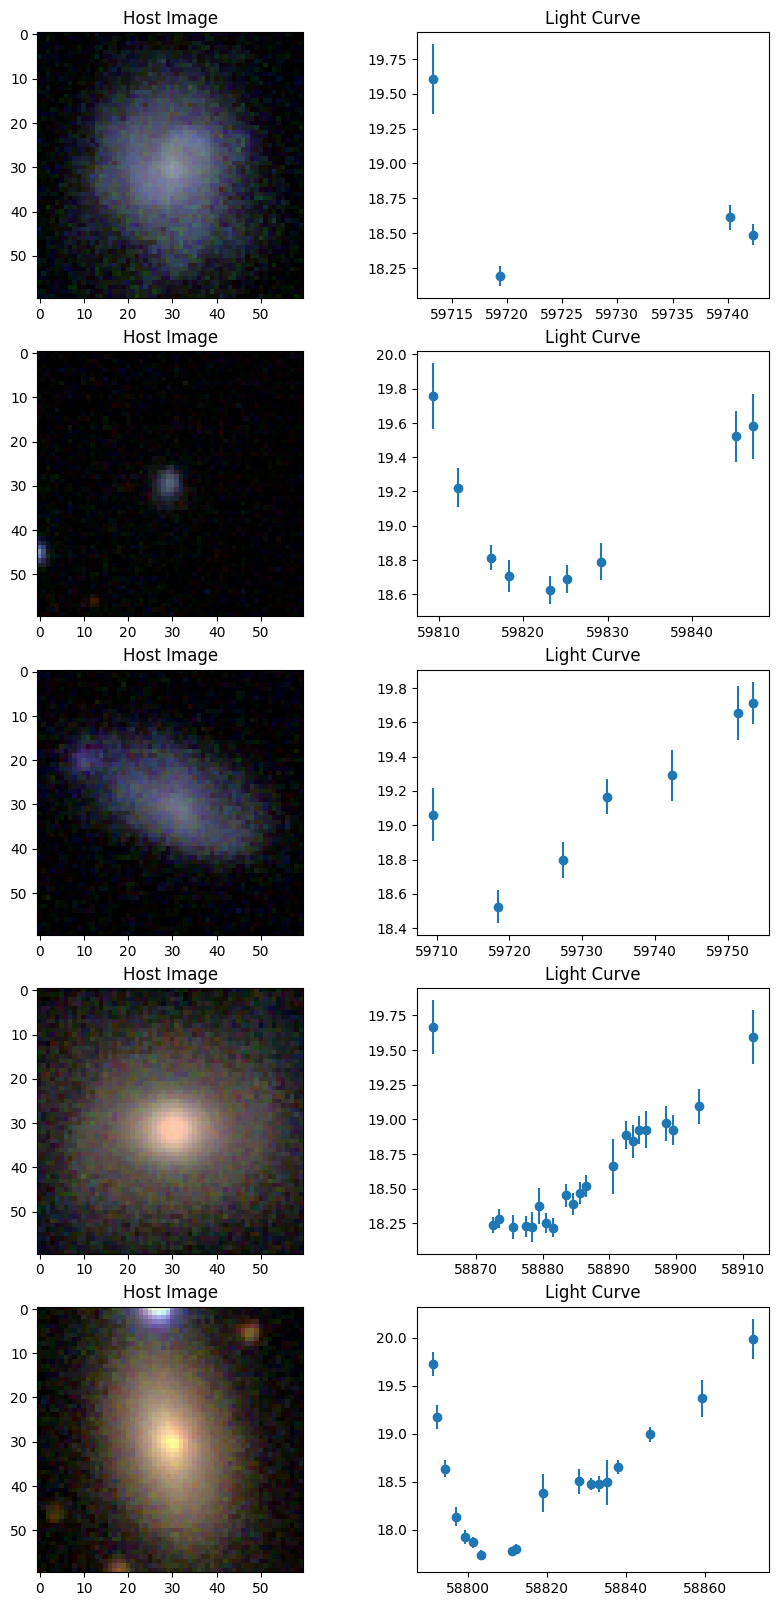

In [7]:
# Plot some corresponding light curves and host images (in two columns)
n_rows = 5
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20))

for i in range(n_rows):
    axs[i, 0].imshow(host_imgs[i].permute(1, 2, 0))
    axs[i, 0].set_title("Host Image")
    axs[i, 1].errorbar(time_ary[i][mask_ary[i]], mag_ary[i][mask_ary[i]], yerr=magerr_ary[i][mask_ary[i]], fmt='o')
    axs[i, 1].set_title("Light Curve")

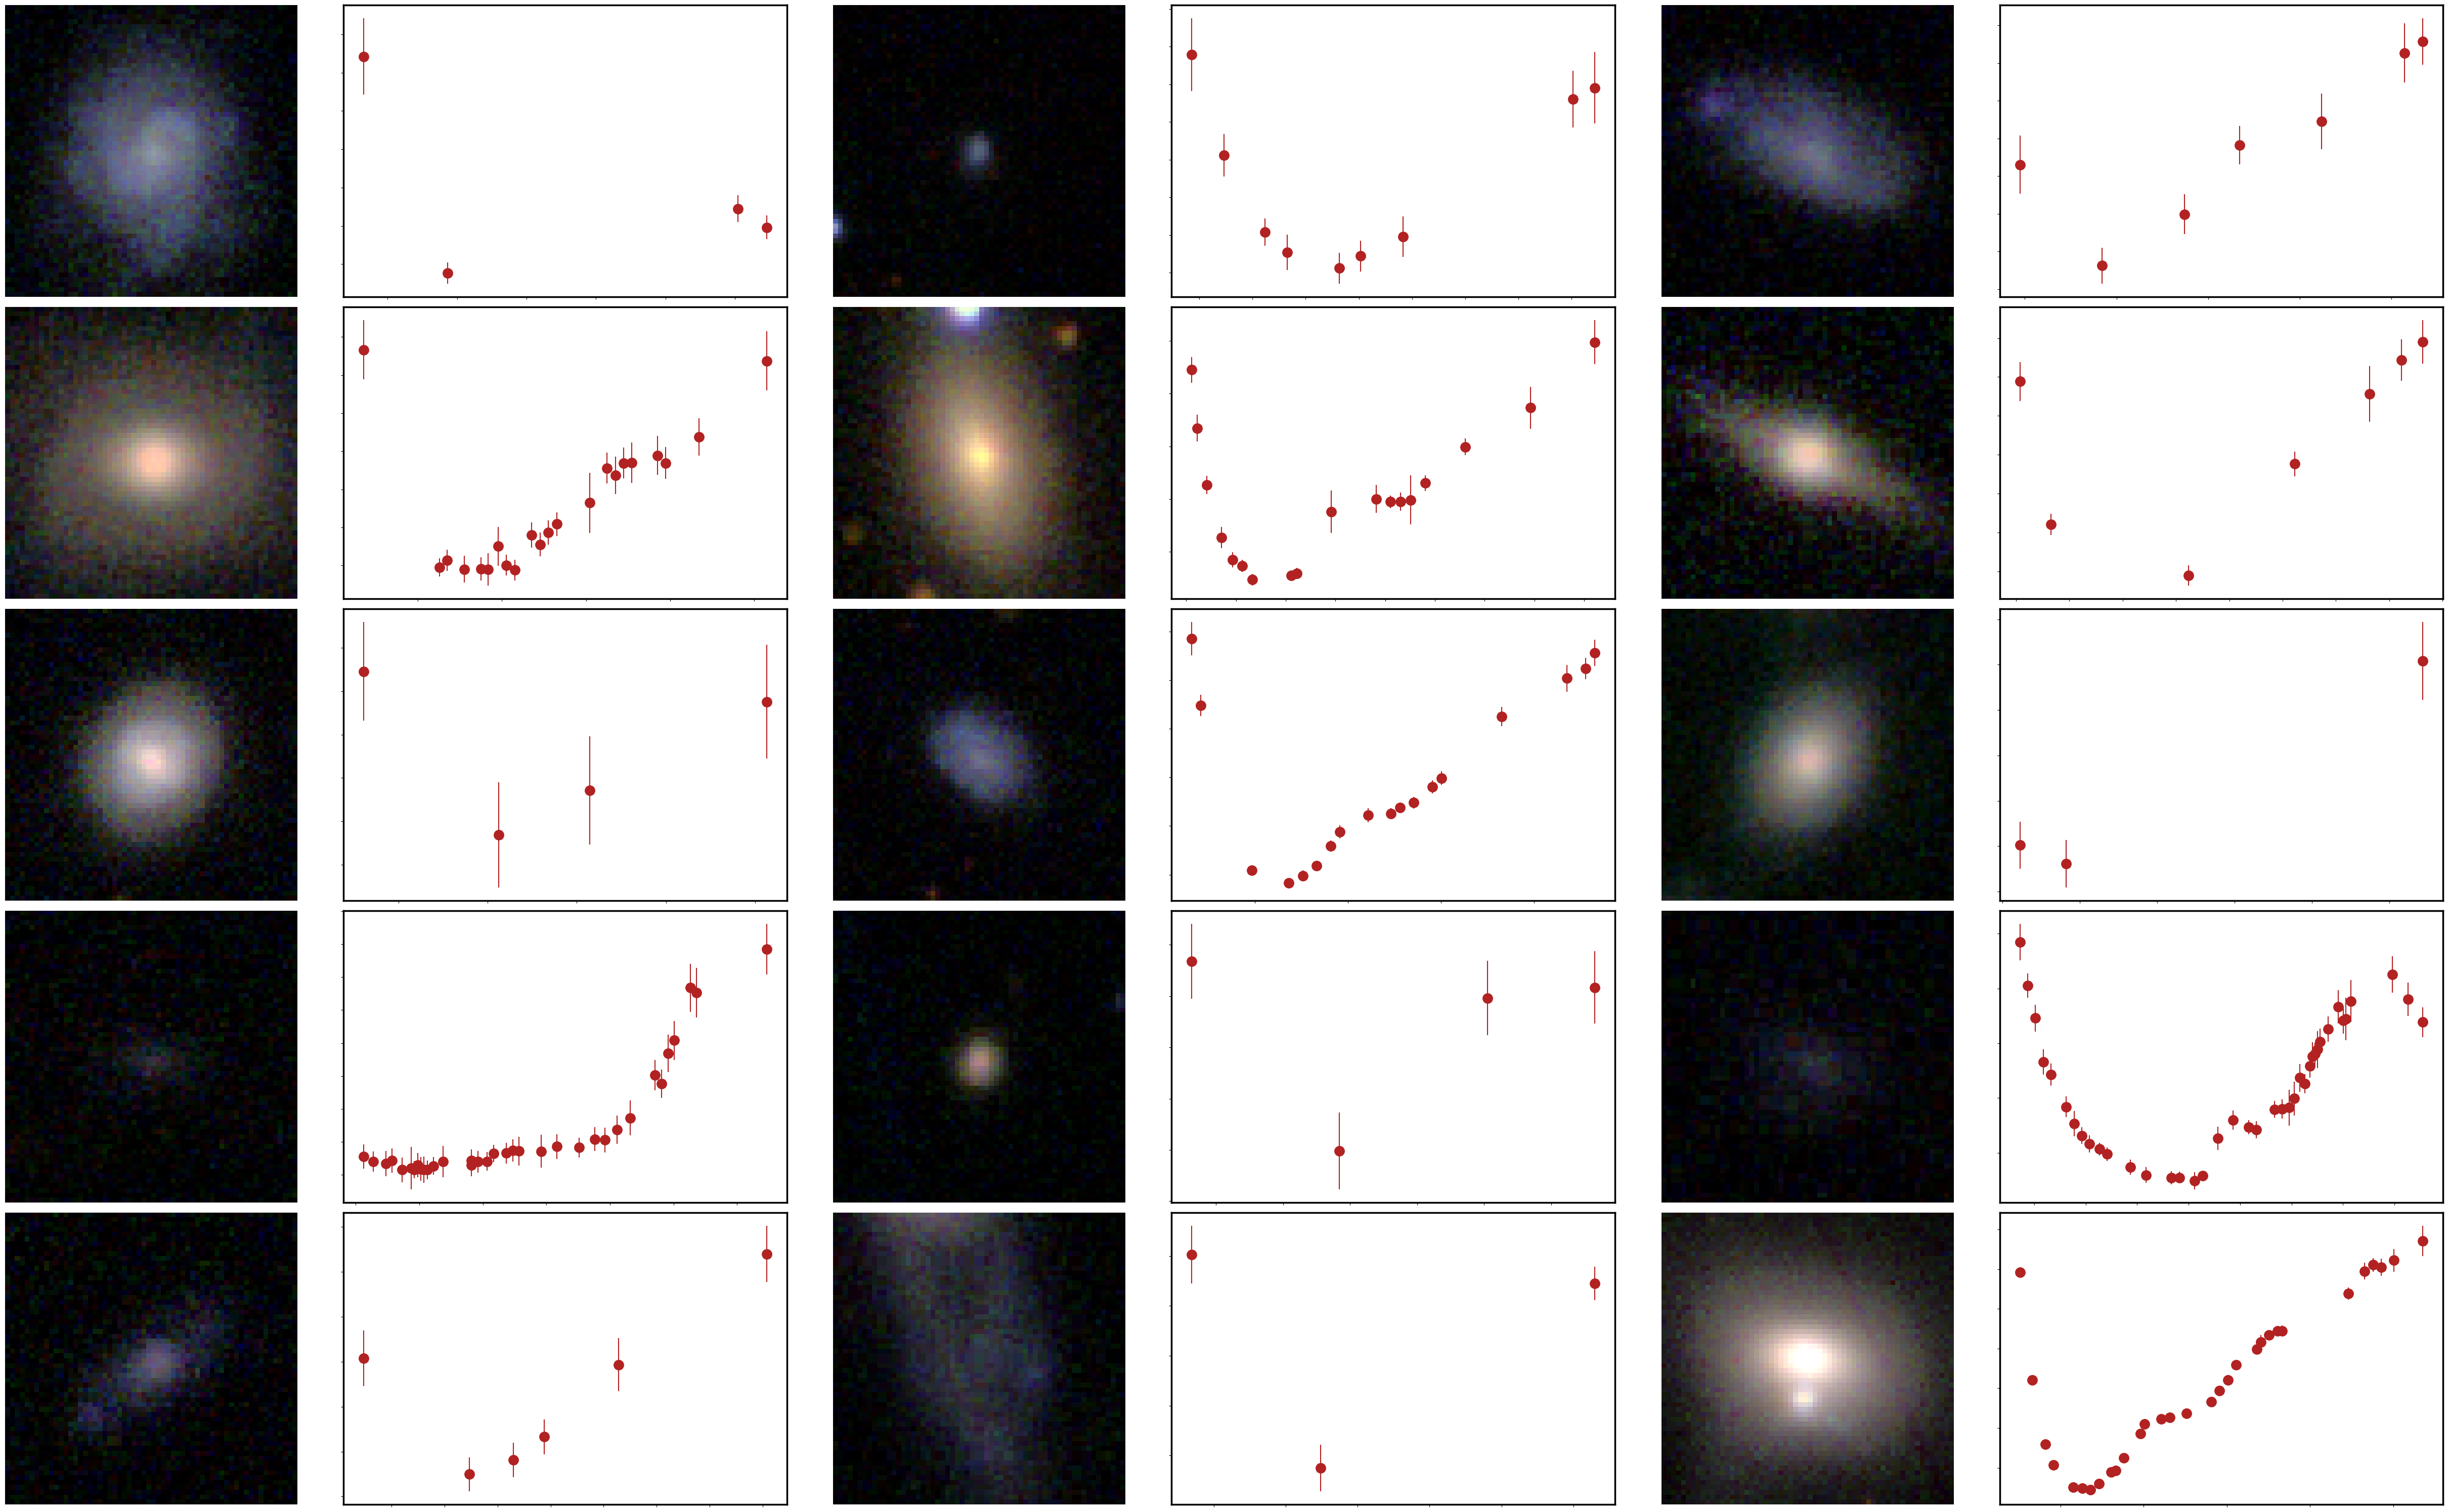

In [8]:
# Banner image

n_pairs_per_row = 3
n_rows = 5  # Assuming we still have 5 rows of data

# Adjusting the number of columns
n_cols = n_pairs_per_row * 2  # Two columns per pair

# Creating a new big grid layout for the plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(50, 30))

for i in range(n_rows):
    for j in range(n_pairs_per_row):
        # Calculating the index for each unique data pair
        index = i * n_pairs_per_row + j

        # Plotting unique host images
        img_col = j * 2  # Column index for image
        axs[i, img_col].imshow(host_imgs[index].permute(1, 2, 0))
        # axs[i, img_col].set_title(f"Host Image {index+1}")
        axs[i, img_col].axis('off')  # Turn off axis for images

        # Plotting unique light curves
        lc_col = img_col + 1  # Column index for light curve
        axs[i, lc_col].errorbar(time_ary[index][mask_ary[index]], 
                                mag_ary[index][mask_ary[index]], 
                                yerr=magerr_ary[index][mask_ary[index]], 
                                fmt='o', ms=14, color='firebrick') 
        
        # Turn off axis labels
        axs[i, lc_col].set_xticklabels([])
        axs[i, lc_col].set_yticklabels([]) 

        # Increase thickness of axis spines
        axs[i, lc_col].spines['top'].set_linewidth(2.5)
        axs[i, lc_col].spines['right'].set_linewidth(2.5)
        axs[i, lc_col].spines['bottom'].set_linewidth(2.5)
        axs[i, lc_col].spines['left'].set_linewidth(2.5)
           

plt.tight_layout()
plt.savefig("./assets/banner.png")

Looks good so far!

### Image encoder

Out host images are pretty simple 60x60 images. Let's try a [ConvMixer](https://arxiv.org/abs/2201.09792) architecture.

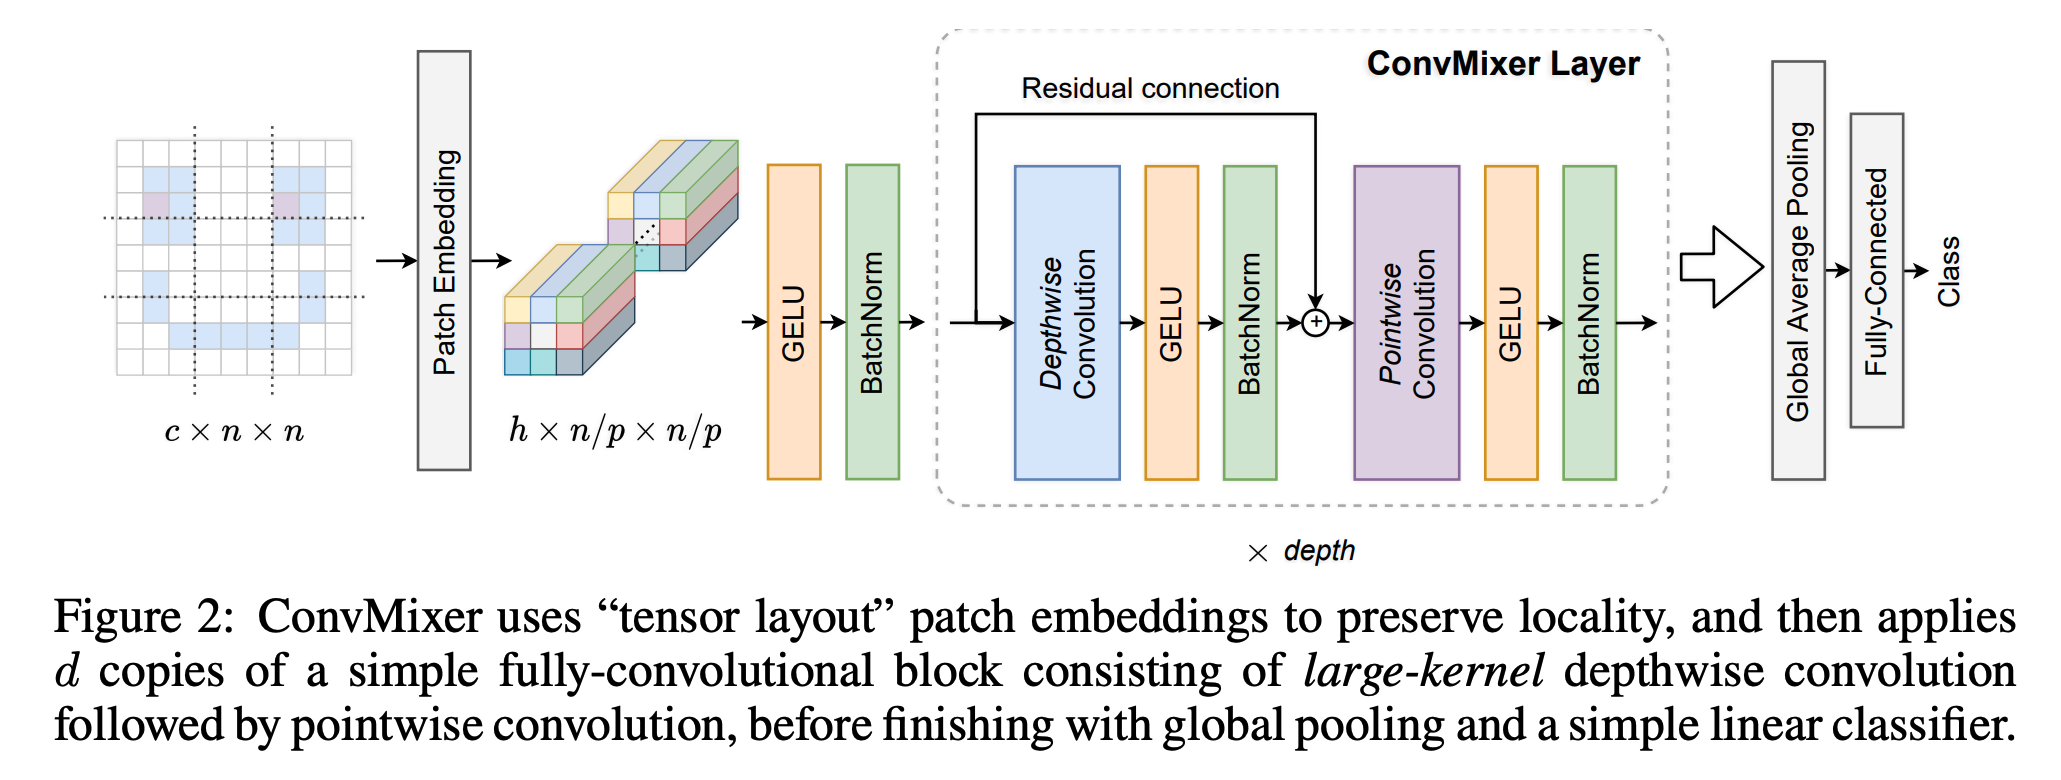

In [9]:
# From https://arxiv.org/pdf/2201.09792.pdf
IPImage(filename='assets/convmixer.png', width=1024)

In [10]:
import torch
import torch.nn as nn

In [11]:
import torch.nn as nn

class Residual(nn.Module):
    """
    A residual block that adds the input to the output of a function.
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        # Apply the function and add the input to the result
        return self.fn(x) + x

class ConvMixer(nn.Module):
    def __init__(self, dim, depth, channels=1, kernel_size=5, patch_size=8, n_out=128, dropout_prob=0.5):
        super(ConvMixer, self).__init__()
        print(dropout_prob)

        # Initial convolution layer
        self.net = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size, bias=False),
            nn.GELU(),
            nn.BatchNorm2d(dim),
        )

        # Adding depth number of ConvMixer layers with dropout
        for _ in range(depth):
            self.net.append(nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim),
                    nn.Dropout(dropout_prob)  # Add dropout here
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim),
                nn.Dropout(dropout_prob)  # Add dropout here
            ))

        # Projection head with dropout
        self.projection = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(dim, 1024),
            nn.GELU(),
            nn.Dropout(dropout_prob),  # Add dropout here
            nn.Linear(1024, n_out)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.net(x)
        x = self.projection(x)
        return x


In [12]:
convmixer = ConvMixer(dim=4, depth=16, channels=3, kernel_size=4, patch_size=2, n_out=128)
convmixer(host_imgs[:2])

0.5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1011.)
  return F.conv2d(input, weight, bias, self.stride,


tensor([[-0.0589, -0.0752,  0.0761, -0.0257,  0.0699, -0.1965,  0.1026, -0.1065,
         -0.0026, -0.0968, -0.2641,  0.0061,  0.0963,  0.1553, -0.0744, -0.1392,
         -0.0614, -0.1186, -0.0057,  0.0787, -0.2498, -0.0456, -0.1794, -0.2477,
         -0.1204,  0.0817,  0.0367, -0.0913, -0.1438, -0.1148, -0.0044,  0.1015,
          0.0355,  0.0191, -0.1205,  0.1862, -0.0564,  0.0980,  0.0667, -0.1260,
         -0.1143,  0.2570, -0.1034,  0.0171, -0.0153,  0.1019,  0.0695, -0.0099,
         -0.0486, -0.0437,  0.1708,  0.0597, -0.0901,  0.0545,  0.0476,  0.2117,
         -0.0375,  0.1116,  0.0402,  0.0315, -0.0203,  0.0491,  0.0682,  0.0016,
         -0.2708,  0.0646,  0.0452,  0.0991, -0.4003,  0.0366, -0.1008,  0.0303,
          0.0867, -0.1795,  0.1069,  0.1949, -0.1634,  0.0820,  0.1407,  0.0585,
          0.1030,  0.0935,  0.1382,  0.1323, -0.0282, -0.0236, -0.2691, -0.0222,
         -0.0167, -0.0089,  0.1555,  0.0993,  0.1686, -0.1135,  0.0340,  0.0649,
         -0.0307,  0.0272, -

### Lightcurve encoder

Similar encoder architecture as before. Try to see if you can transfer the transformer weights from the previous notebooks and potentially freeze them, and what effect this has on the downstream task.

In [13]:
import math
from models.transformer_utils import Transformer

class TimePositionalEncoding(nn.Module):

    def __init__(self, d_emb):
        """
        Inputs
            d_model - Hidden dimensionality.
        """
        super().__init__()
        self.d_emb = d_emb

    def forward(self, t):
        pe = torch.zeros(t.shape[0], t.shape[1], self.d_emb).to(t.device)  # (B, T, D)
        div_term = torch.exp(torch.arange(0, self.d_emb, 2).float() * (-math.log(10000.0) / self.d_emb))[None, None, :].to(t.device)  # (1, 1, D / 2)
        t = t.unsqueeze(2)  # (B, 1, T)
        pe[:, :, 0::2] = torch.sin(t * div_term)  # (B, T, D / 2)
        pe[:, :, 1::2] = torch.cos(t * div_term)  # (B, T, D / 2)
        return pe  # (B, T, D)

class TransformerWithTimeEmbeddings(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, n_out, **kwargs):
        """
        :param n_out: Number of output emedding.
        :param kwargs: Arguments for Transformer.
        """
        super().__init__()
        
        self.embedding_mag = nn.Linear(in_features=1, out_features=kwargs['emb'])
        self.embedding_t = TimePositionalEncoding(kwargs['emb'])
        self.transformer = Transformer(**kwargs)

        self.projection = nn.Linear(kwargs['emb'], n_out)

    def forward(self, x, t, mask=None):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        t = t - t[:, 0].unsqueeze(1)
        t_emb = self.embedding_t(t)
        x = self.embedding_mag(x) + t_emb
        x = self.transformer(x, mask)  # (B, T, D)
        
        # Zero out the masked values
        x = x * mask[:, :, None]
                    
        # Max pool
        x = x.max(dim=1)[0]
        
        x = self.projection(x)
        return x

transformer = TransformerWithTimeEmbeddings(n_out=128, emb=128, heads=1, depth=1)

In [14]:
# Time and mag tensors
time = torch.from_numpy(time_ary).float()
mag = torch.from_numpy(mag_ary).float()
mask = torch.from_numpy(mask_ary).bool()
magerr = torch.from_numpy(magerr_ary).float()

In [15]:
# Pass a batch through
transformer(mag[:4][..., None], time[:4], mask[:4]).shape

torch.Size([4, 128])

### Create dataset

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


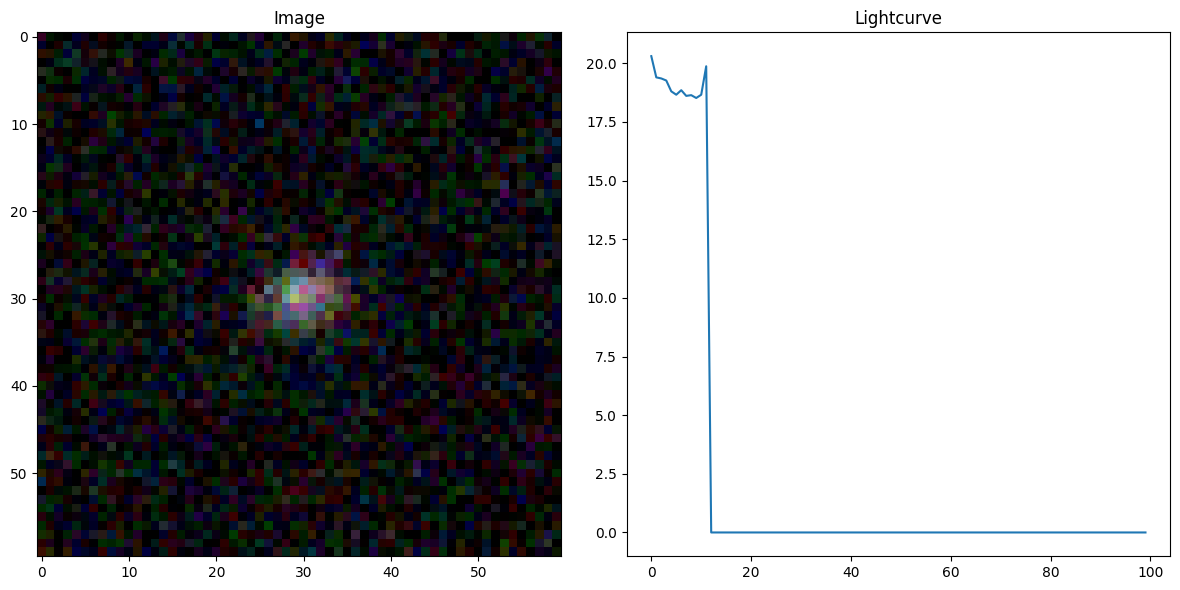

In [16]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import RandomRotation

val_fraction = 0.05
batch_size = 64
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(host_imgs, mag, time, mask, magerr)  # Include magerr in the dataset


dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
#train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

# Custom data loader with noise augmentation using magerr
class NoisyDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, noise_level_img, noise_level_mag, shuffle=True, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
        self.max_noise_intensity = noise_level_img
        self.noise_level_mag = noise_level_mag

    def __iter__(self):
        for batch in super().__iter__():
            # Add random noise to images and time-magnitude tensors
            host_imgs, mag, time, mask, magerr = batch

            # Calculate the range for the random noise based on the max_noise_intensity
            noise_range = self.max_noise_intensity * torch.std(host_imgs)

            # Generate random noise within the specified range
            noisy_imgs = host_imgs + (2 * torch.rand_like(host_imgs) - 1) * noise_range

            # Add Gaussian noise to mag using magerr
            noisy_mag = mag + torch.randn_like(mag) * magerr * self.noise_level_mag

            # Randomly apply rotation by multiples of 90 degrees
            rotation_angle = torch.randint(0, 4, (noisy_imgs.size(0),)) * 90
            rotated_imgs = []

            # Apply rotation to each image
            for i in range(noisy_imgs.size(0)):
                rotated_img = RandomRotation([rotation_angle[i], rotation_angle[i]])(noisy_imgs[i])
                rotated_imgs.append(rotated_img)

            # Stack the rotated images back into a tensor
            rotated_imgs = torch.stack(rotated_imgs)
            
            # Return the noisy batch
            yield noisy_imgs, noisy_mag, time, mask

# Define the noise levels for images and magnitude (multiplied by magerr)
noise_level_img = 1  # Adjust as needed
noise_level_mag = 1  # Adjust as needed

val_noise = 0

# Create custom noisy data loaders
train_loader = NoisyDataLoader(dataset_train, batch_size=batch_size, noise_level_img=noise_level_img, noise_level_mag=noise_level_mag, shuffle=True, num_workers=8, pin_memory=True)
val_loader = NoisyDataLoader(dataset_val, batch_size=batch_size, noise_level_img=val_noise, noise_level_mag=val_noise, shuffle=False, num_workers=8, pin_memory=True)
testim,testmag,_,_ = next(iter(train_loader))

# Plot the image
plt.figure(figsize=(12, 6))

# Create a subplot for the image
plt.subplot(1, 2, 1)
plt.imshow(testim[0].permute(1, 2, 0))
plt.title("Image")

# Create a subplot for the lightcurve
plt.subplot(1, 2, 2)
plt.plot(testmag[0].numpy())

plt.title("Lightcurve")

plt.tight_layout()

### Contrastive-style losses

In [17]:
pip install pytorch_lightning

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch.nn.functional as F
import pytorch_lightning as pl

The standard CLIP architecture uses a bidirection (symmetric between modalities, e.g. image and text) version of the so-called SimCLR loss to compute alignment between image and light curve representations.
$$\mathcal{L}_\mathrm{CLIP}=-\frac{1}{2|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|}\left(\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_i \cdot y_j}}+\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_j \cdot y_i}}\right)$$

The standard CLIP loss can be quite unstable due to the small number of positive pairs and large number of negative pairs in a batch. It can also often require very large batch sizes to work well. There are many proposed ways of overcoming this, e.g. see https://lilianweng.github.io/posts/2021-05-31-contrastive/ for some approaches. 

In addition to theh softmax-based loss, we'll also try a sigmoid loss, from https://arxiv.org/abs/2303.15343:
$$\mathcal{L}_\mathrm{SigLIP}=-\frac{1}{|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|} \sum_{j=1}^{|\mathcal{B}|} \log \frac{1}{1+e^{z_{i j}\left(-t\, {x}_i \cdot {y}_j+b\right)}}$$
where $x_i$ and $y_j$ are the normalized image and light curve representations, respectively, and $z_{ij}$ is a binary indicator of whether the image and light curve are a match or not.

Let's implement these two.

In [19]:
def clip_loss(image_embeddings, text_embeddings, logit_scale=1., logit_bias=0., image_encoder = None, lightcurve_encoder = None, printing = False ):
    
    logit_scale = logit_scale.exp()
    
    logits = (text_embeddings @ image_embeddings.T) * logit_scale + logit_bias
    
    images_loss = nn.LogSoftmax(dim=1)(logits)
    texts_loss = nn.LogSoftmax(dim=0)(logits)
    
    images_loss = -images_loss.diag()
    texts_loss = -texts_loss.diag()

    n = min(len(image_embeddings), len(text_embeddings))
    
    images_loss = images_loss.sum() / n
    texts_loss = texts_loss.sum() / n

    loss = (images_loss + texts_loss) / 2
    if printing:
        print(f'just clip loss {loss}')
        
    if (image_encoder and lightcurve_encoder ):
        picture_loss_reg = 0
        for param in image_encoder.parameters():
            picture_loss_reg += 0*torch.mean(torch.abs(param))
        if printing:
            print(f"picture {picture_loss_reg}")
        loss += picture_loss_reg
        light_loss_reg = 0
        for param in lightcurve_encoder.parameters():
            light_loss_reg += 0*torch.mean(torch.abs(param))
        if printing:
            print(f"light {light_loss_reg}")
        loss += light_loss_reg
    return loss    

def sigmoid_loss(image_embeds, text_embeds, logit_scale=1., logit_bias=2.73):
    """ Sigmoid-based CLIP loss, from https://arxiv.org/abs/2303.15343
    """
    
    logit_scale = logit_scale.exp()
    
    bs = text_embeds.shape[0]
    
    labels = 2 * torch.eye(bs) - torch.ones((bs, bs))
    labels = labels.to(text_embeds.device)

    logits = text_embeds @ image_embeds.t() * logit_scale + logit_bias
    logits = logits.to(torch.float64)
    
    positive_loss = -torch.mean(torch.log(torch.sigmoid(labels * logits)))
    
    shifted_image_embeds = torch.roll(image_embeds, 1, dims=0)
    negative_logits = text_embeds @ shifted_image_embeds.t() * logit_scale + logit_bias    
    negative_loss = -torch.mean(torch.log(1 - torch.sigmoid(negative_logits)))
    
    
    loss = positive_loss + negative_loss
    
    return loss

In [20]:
class LightCurveImageCLIP(pl.LightningModule):
    def __init__(self, 
                 enc_dim=128,
                 logit_scale=10.,
                 transformer_kwargs={"n_out":128, "emb":256, "heads":2, "depth":8}, 
                 conv_kwargs = {'dim': 32, 'depth': 8, 'channels': 3, 'kernel_size': 5, 'patch_size': 10, 'n_out': 128}, 
                 optimizer_kwargs={"weight_decay":0.0}, lr=1e-4,
                 loss='sigmoid'):
        super().__init__()
        
        self.lr = lr
        self.optimizer_kwargs = optimizer_kwargs
        self.enc_dim = enc_dim

        # Make temperature and logit bias a learnable parameter
        # Init values log(10) and -10 from https://arxiv.org/abs/2303.15343
        self.logit_scale = nn.Parameter(torch.tensor(math.log(logit_scale)), requires_grad=True)
        self.logit_bias = nn.Parameter(torch.tensor(-10.), requires_grad=True)

        # Encoders
        self.lightcurve_encoder = TransformerWithTimeEmbeddings(**transformer_kwargs)
        self.image_encoder = ConvMixer(**conv_kwargs)

        # Projection heads to common embedding space
        self.lightcurve_projection = nn.Linear(transformer_kwargs['n_out'], enc_dim)
        self.image_projection = nn.Linear(conv_kwargs['n_out'], enc_dim)
        
        self.loss = loss

    def forward(self, x_img, x_lc, t_lc, mask_lc=None):
        
        # Light curve encoder
        x_lc = self.lightcurve_embeddings_with_projection(x_lc, t_lc, mask_lc)
        
        # Image encoder
        x_img = self.image_embeddings_with_projection(x_img)
    
        # Normalized embeddings
        return x_img, x_lc
    
    def image_embeddings_with_projection(self, x_img):
        """ Convenience function to get image embeddings with projection
        """
        x_img = self.image_encoder(x_img)
        x_img = self.image_projection(x_img)
        return x_img / x_img.norm(dim=-1, keepdim=True)
    
    def lightcurve_embeddings_with_projection(self, x_lc, t_lc, mask_lc=None):
        """ Convenience function to get light curve embeddings with projection
        """
        x_lc = x_lc[..., None]  # Add channel dimension
        x_lc = self.lightcurve_encoder(x_lc, t_lc, mask_lc)
        x_lc = self.lightcurve_projection(x_lc)
        return x_lc / x_lc.norm(dim=-1, keepdim=True)

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}
    
    def training_step(self, batch, batch_idx):
        x_img, x_lc, t_lc, mask_lc = batch
        x_img, x_lc = self(x_img, x_lc, t_lc, mask_lc)
        if self.loss == "sigmoid":
            loss = sigmoid_loss(x_img, x_lc, self.logit_scale, self.logit_bias).mean()
        elif self.loss == "softmax":
            loss = clip_loss(x_img, x_lc, self.logit_scale, self.logit_bias,self.image_encoder,self.lightcurve_encoder).mean()
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

    def validation_step(self, batch, batch_idx):
        x_img, x_lc, t_lc, mask_lc = batch
        x_img, x_lc = self(x_img, x_lc, t_lc, mask_lc)
        if self.loss == "sigmoid":
            loss = sigmoid_loss(x_img, x_lc, self.logit_scale, self.logit_bias).mean()
        elif self.loss == "softmax":
            loss = clip_loss(x_img, x_lc, self.logit_scale, self.logit_bias,self.image_encoder,self.lightcurve_encoder).mean()
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

In [21]:
transformer_kwargs={"n_out":32, "emb":32, "heads":2, "depth":1, "dropout": 0.0 }
conv_kwargs = {'dim': 32, 'depth': 2, 'channels': 3, 'kernel_size': 5, 'patch_size': 10, 'n_out': 32,'dropout_prob':0.0}
optimizer_kwargs = {"weight_decay":0.0}

clip_model = LightCurveImageCLIP(logit_scale=20., lr=1e-2, loss='softmax',transformer_kwargs = transformer_kwargs,conv_kwargs=conv_kwargs)

x_img, x_lc, t_lc, mask_lc = next(iter(train_loader))
x_img, x_lc = clip_model(x_img, x_lc, t_lc, mask_lc)

sigmoid_loss(x_img, x_lc, clip_model.logit_scale).mean(), clip_loss(x_img, x_lc, clip_model.logit_scale).mean()

0.0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(tensor(5.7873, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(4.2129, grad_fn=<MeanBackward0>))

In [29]:
trainer = pl.Trainer(max_epochs=2, accelerator='gpu')
trainer.fit(model=clip_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/jet/home/thelfer/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /jet/home/thelfer/iaifi-hackathon-2024/multimodal_ssl/notebooks/lightning_logs/version_21818377/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                          | Params
------------------------------------------------------------------------
0 | lightcurve_encoder    | TransformerWithTimeEmbeddings | 13.7 K
1 | image_encoder         | ConvMixer                     | 80.3 K
2 | lightcurve_projection | Linear                        | 4.2 K 
3 | image_projection      | Linear                        | 4.2 K 
  | other params          | n/a                           | 2     
---------------------------------------------------------------------

Epoch 0: 100%|██████████| 77/77 [00:04<00:00, 16.64it/s, v_num=2.18e+7]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 77/77 [00:04<00:00, 16.16it/s, v_num=2.18e+7, val_loss=4.130, train_loss=4.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 77/77 [00:05<00:00, 14.25it/s, v_num=2.18e+7, val_loss=4.130, train_loss=4.160]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 77/77 [00:05<00:00, 14.18it/s, v_num=2.18e+7, val_loss=4.130, train_loss=4.160]


Play around with various hyperparameters. Does the loss go down/converge? **Is there actually a strong correlation between the host images and light curves?** How can you test this? (E.g. -> overfit on a small batch).

## Downstream task: retrieval

Try your hand at various downstream tasks: compute embeddings over images, see if they are able to identify similar images/light curves better than the base model. See if the model has learned useful joint representations by trying retrieval across modalities (image to light curve and vice versa).

In [30]:
clip_model = clip_model.eval()

In [72]:
def cosine_similarity(a, b, temperature=1):
    a_norm = a / a.norm(dim=-1, keepdim=True)
    b_norm = b / b.norm(dim=-1, keepdim=True)
    
    logits = a_norm @ b_norm.T * temperature
    return logits.squeeze()

In [32]:
emb_host = clip_model.image_embeddings_with_projection(host_imgs[:100])

tensor([33, 15, 80,  0, 63, 78, 76, 74, 86, 36])


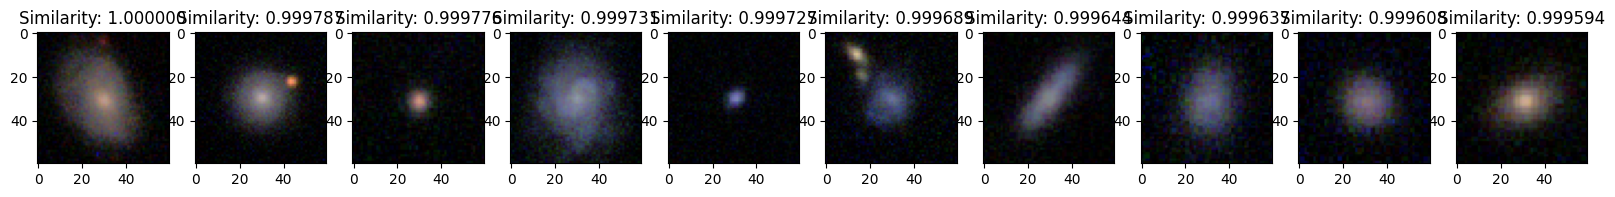

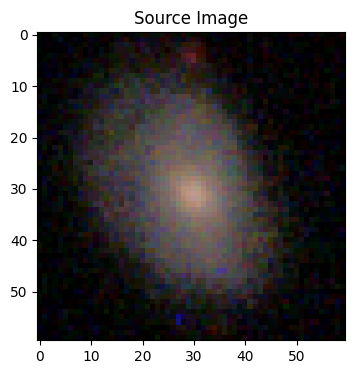

In [33]:
def plot_retrieved_im(idx_src):
        
    emb_src = clip_model.image_embeddings_with_projection(host_imgs[idx_src:idx_src + 1])

    # Compute cosine similarity between host images and source image
    cos_sim = cosine_similarity(emb_host, emb_src,)

    # Get the top 10 most similar host images
    top_10_idx = torch.argsort(cos_sim, descending=True)[:10]
    print(top_10_idx)

    # Plot the top 10 most similar host images in on row
    fig, axs = plt.subplots(1, 10, figsize=(20, 5))

    for i, idx in enumerate(top_10_idx):
        axs[i].imshow(host_imgs[idx].permute(1, 2, 0))
        axs[i].set_title(f"Similarity: {cos_sim[idx]:.6f}")

    # Plot the source image
    plt.figure(figsize=(4, 4))
    plt.imshow(host_imgs[idx_src].permute(1, 2, 0))
    plt.title("Source Image")

plot_retrieved_im(33)

tensor([16, 34, 65, 12, 80, 64,  2, 86, 37, 63])


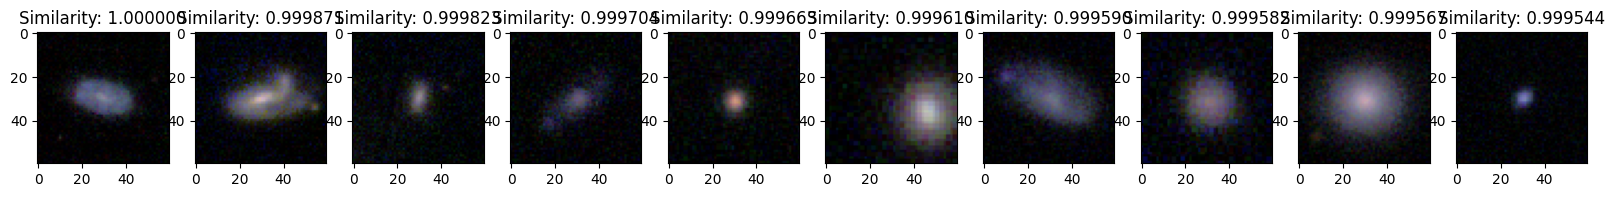

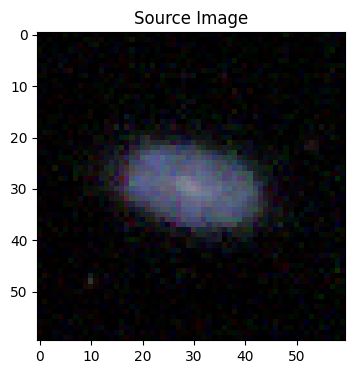

In [34]:
plot_retrieved_im(16)

Try the same thing with light curves.

In [35]:
# Light curve retrieval
emb_host = clip_model.lightcurve_embeddings_with_projection(mag[:5], time[:5], mask[:5])

In [36]:
idx_src = 4
emb_src = clip_model.lightcurve_embeddings_with_projection(mag[idx_src:idx_src + 1], time[idx_src:idx_src + 1], mask[idx_src:idx_src + 1])

tensor([4, 3, 2, 0, 1])


Text(0.5, 1.0, 'Source Light Curve')

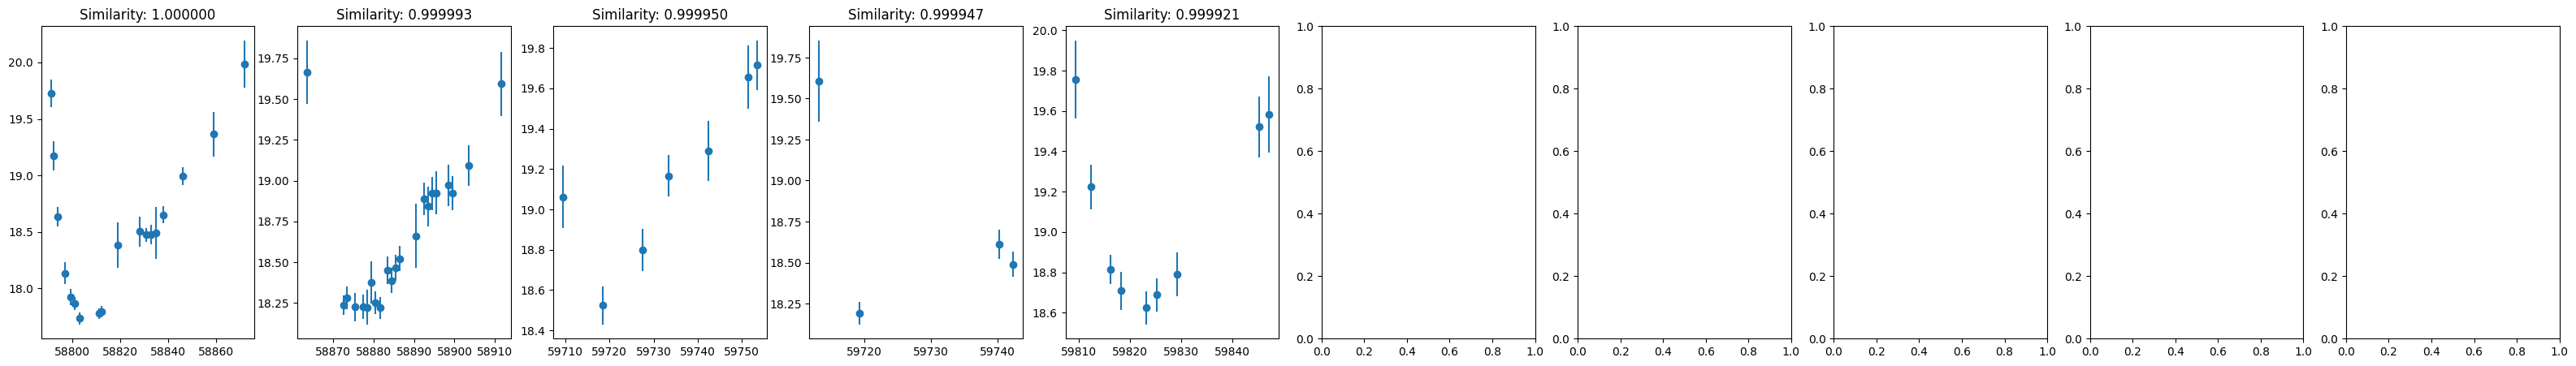

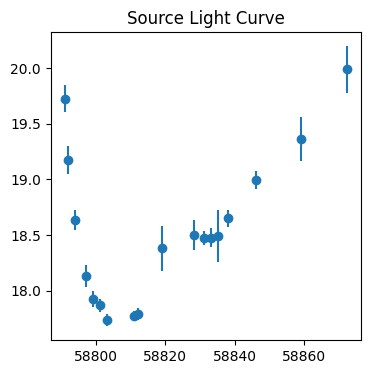

In [37]:
cos_sim = cosine_similarity(emb_host, emb_src)

# Plot the top 10 most similar light curves in a row

top_10_idx = torch.argsort(cos_sim, descending=True)[:10]

fig, axs = plt.subplots(1, 10, figsize=(40, 5))

for i, idx in enumerate(top_10_idx):
    axs[i].errorbar(time_ary[idx][mask_ary[idx]], mag_ary[idx][mask_ary[idx]], yerr=magerr_ary[idx][mask_ary[idx]], fmt='o')
    axs[i].set_title(f"Similarity: {cos_sim[idx]:.6f}")

print(top_10_idx)    
# Plot the source light curve
plt.figure(figsize=(4, 4))
plt.errorbar(time_ary[idx_src][mask_ary[idx_src]], mag_ary[idx_src][mask_ary[idx_src]], yerr=magerr_ary[idx_src][mask_ary[idx_src]], fmt='o')
plt.title("Source Light Curve")

Looks like we can pick up similar light curves. Can you improve the model -- the light curves encoder (see last notebook), the image model, or the loss function?

In [38]:
# Light curve retrieval
emb_host = clip_model.lightcurve_embeddings_with_projection(mag[:100], time[:100], mask[:100])

In [39]:
idx_src = 4
emb_src = clip_model.image_embeddings_with_projection(host_imgs[idx_src:idx_src + 1])

tensor([58, 36, 20, 78, 14, 68, 48, 79, 52, 81])


Text(0.5, 1.0, 'Source Light Curve')

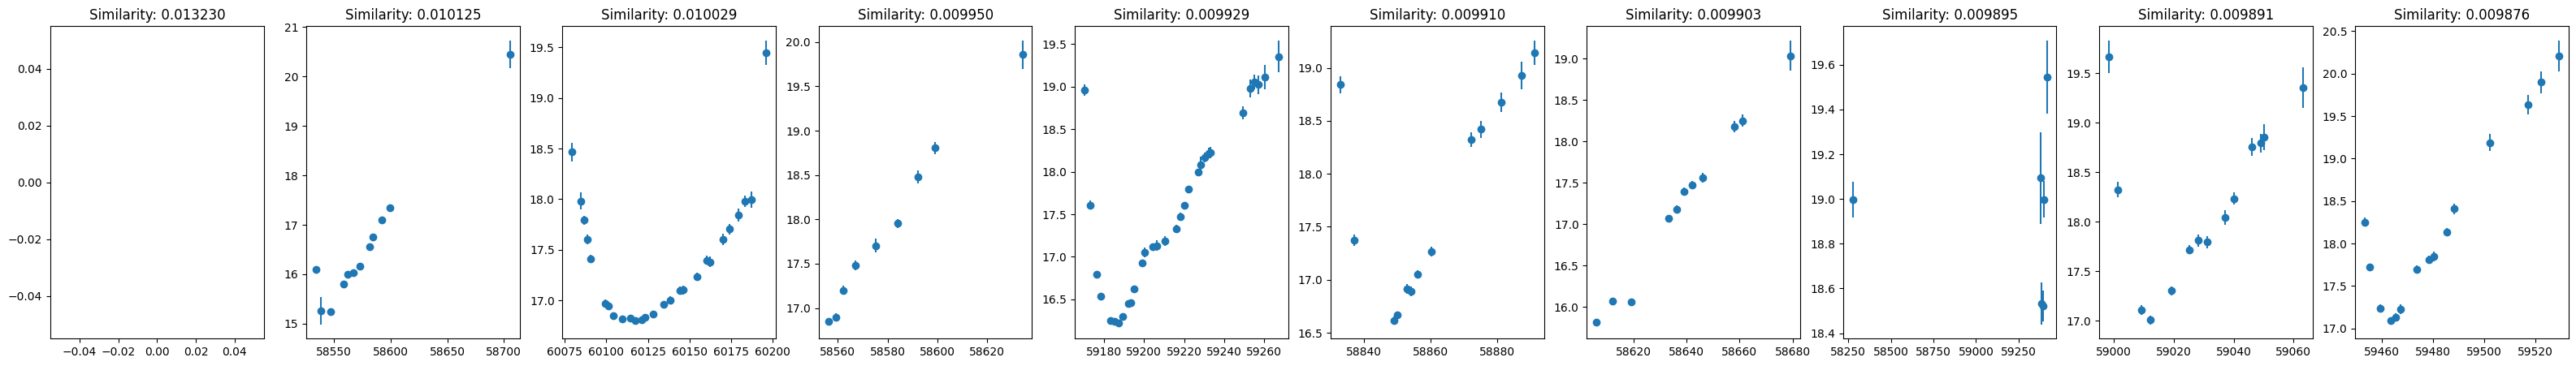

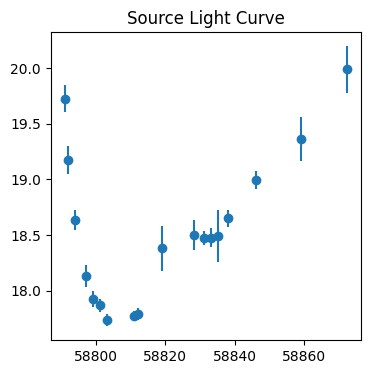

In [40]:
cos_sim = cosine_similarity(emb_host, emb_src)

# Plot the top 10 most similar light curves in a row

top_10_idx = torch.argsort(cos_sim, descending=True)[:10]

fig, axs = plt.subplots(1, 10, figsize=(40, 5))

for i, idx in enumerate(top_10_idx):
    axs[i].errorbar(time_ary[idx][mask_ary[idx]], mag_ary[idx][mask_ary[idx]], yerr=magerr_ary[idx][mask_ary[idx]], fmt='o')
    axs[i].set_title(f"Similarity: {cos_sim[idx]:.6f}")

print(top_10_idx)    
# Plot the source light curve
plt.figure(figsize=(4, 4))
plt.errorbar(time_ary[idx_src][mask_ary[idx_src]], mag_ary[idx_src][mask_ary[idx_src]], yerr=magerr_ary[idx_src][mask_ary[idx_src]], fmt='o')
plt.title("Source Light Curve")

In [41]:
emb_host = clip_model.image_embeddings_with_projection(host_imgs.detach())

In [42]:
idx_src = 40
emb_src = clip_model.lightcurve_embeddings_with_projection(mag[idx_src:idx_src + 1], time[idx_src:idx_src + 1], mask[idx_src:idx_src + 1])

tensor([2564, 3379, 2946, 4491, 1931, 1695, 4483, 1704, 4254, 4813])


Text(0.5, 1.0, 'Source Image')

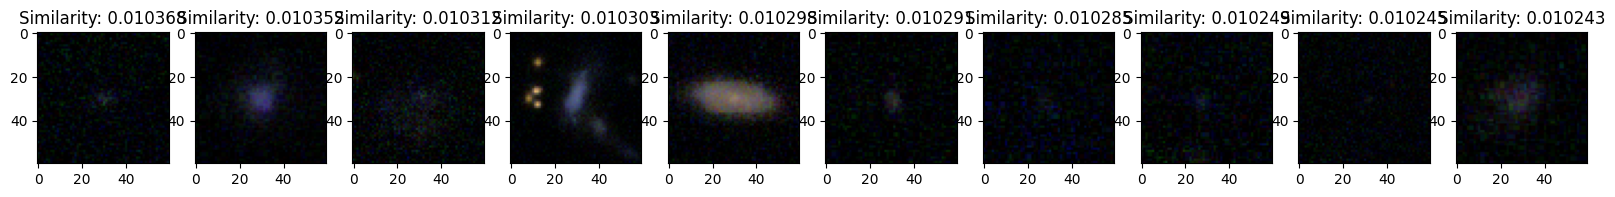

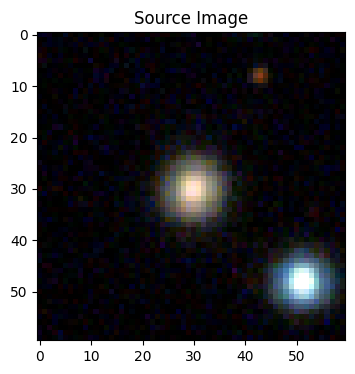

In [43]:
# Compute cosine similarity between host images and source image
cos_sim = cosine_similarity(emb_host, emb_src,)

# Get the top 10 most similar host images
top_10_idx = torch.argsort(cos_sim, descending=True)[:10]
print(top_10_idx)

# Plot the top 10 most similar host images in on row
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for i, idx in enumerate(top_10_idx):
    axs[i].imshow(host_imgs[idx].permute(1, 2, 0))
    axs[i].set_title(f"Similarity: {cos_sim[idx]:.6f}")

# Plot the source image
plt.figure(figsize=(4, 4))
plt.imshow(host_imgs[idx_src].permute(1, 2, 0))
plt.title("Source Image")

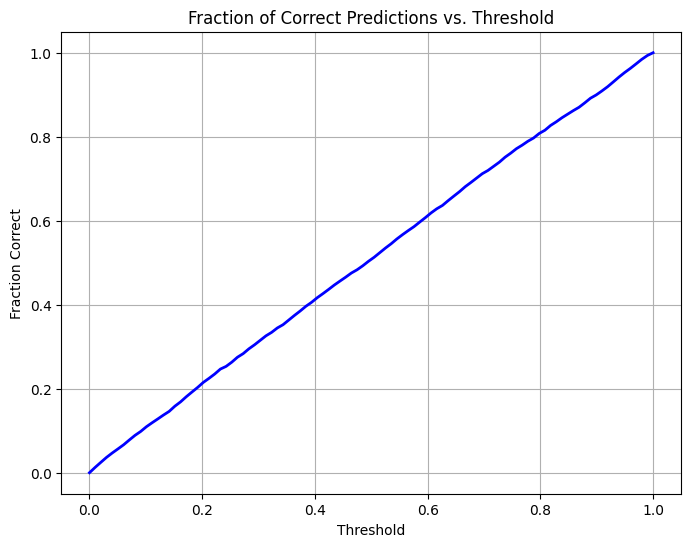

In [74]:
# Create an array of thresholds for similarity
thresholds = np.linspace(0, 1, 100)

# Calculate embeddings for the host light curves
emb_host = clip_model.lightcurve_embeddings_with_projection(mag.detach(), time.detach(), mask.detach())
imgs = []

# Iterate through the host images
for idx, img in enumerate(host_imgs):
    emb_src = clip_model.image_embeddings_with_projection(img.detach().unsqueeze(0))
    
    # Calculate cosine similarity between host light curves and the current source image
    cos_sim = cosine_similarity(emb_host, emb_src)
    
    # Get the indices of host light curves sorted by similarity in descending order
    idx_sorted = torch.argsort(cos_sim, descending=True)
    
    num_right = []
    
    # Calculate the number of correct predictions for each threshold
    for threshold in thresholds:
        num_right.append(idx in idx_sorted[:int(threshold * len(host_imgs))])
    
    imgs.append(num_right)

# Calculate the fraction of correct predictions at each threshold
fraction_correct = np.sum(imgs, axis=0) / len(host_imgs)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fraction_correct, color='b', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Fraction Correct')
plt.title('Fraction of Correct Predictions vs. Threshold')
plt.grid(True)
plt.show()

### Downstream tasks: detecting interesting samples from a big survey sample

Since we have access to a huge collection of (bulk) light curves (see `xx_ssl_lightcurve_encoder.ipynb`), we can also try to find interesting samples from this super noisy dataset based on the learned multimodal representations, by asking which light curves from the bulk samples are similar to given "interesting" light curves from the BTS sample.

### Downstream tasks: fine-tuning and classification

Since we also have access to properties like redshift, we can train a regression head on top of the learned representations, to then classify the bulk light curves.

In [ ]:
df_properties = pd.read_csv("../data/ZTFBTS/ZTFBTS_TransientTable.csv")
df_properties.head()

In particular, try to just do linear regression (add a single `nn.Linear` layer on top) after freezing the learned encoder weights from either image and/or light curve representations to see if you can do inference on e.g. the redshift.